In [28]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
import pandas as pd
from sklearn.metrics import davies_bouldin_score

import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import rc_context
import patchworklib as pw
from utils.preprocessing_funcs import get_var_features_num, is_raw_counts


from IPython.display import display
from os import path
import session_info
import logging
from tempfile import TemporaryDirectory
from os import system

logging.basicConfig(level=logging.ERROR)

In [29]:
# -.-|m { input: false, output: false, input_fold: show}
"in the following cell, override the default pipeline parameters if needed"
HVG_BY_BATCH = False
VARIABLE_FEATURES = 0.1  # a fraction between 0.0 and 1.0 or a number of genes.
CLUSTERING_RANGE = [
    0.0,
    3.0,
    0.2,
]  # Range of resolution for clustering, (min, max, step).


# TODO: Check the best implementation for variable regression
# REGRESS_VARIABLES = []  # List: Variables to regress out (default: []).

# Config

In [30]:
## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [31]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
FINAL_RESOLUTION = config["clustering"]["FINAL_RESOLUTION"]

In [32]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Normalize object

In [33]:
var_features = get_var_features_num(adata, VARIABLE_FEATURES)


if COUNTS_LAYER == "X":
    adata["counts"] = adata.X.copy()
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER].copy()
else:
    raise ValueError(
        "obj.X seems to be normalized and and the {COUNTS_LAYER} layer can't be found in the object"
    )

if NORMALIZATION_METHOD == "log_norm":
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X.copy()

    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
    # Similair to Seurat FindVariableFeatures(method='vst')
    if HVG_BY_BATCH:
        sc.pp.highly_variable_genes(
            adata, n_top_genes=var_features, batch_key="sample", flavor="seurat_v3"
        )
    else:
        sc.pp.highly_variable_genes(
            adata, n_top_genes=var_features, batch_key=None, flavor="seurat_v3"
        )


if NORMALIZATION_METHOD == "p_residuals":
    # Recipie for variable feature selection, pearson normalization, and PCA
    adata = sc.experimental.pp.recipe_pearson_residuals(
        adata=adata, n_top_genes=var_features
    )
    adata["p_residuals"] = adata.X.copy()

# Select Variable Features

number of variable genes is: 3660


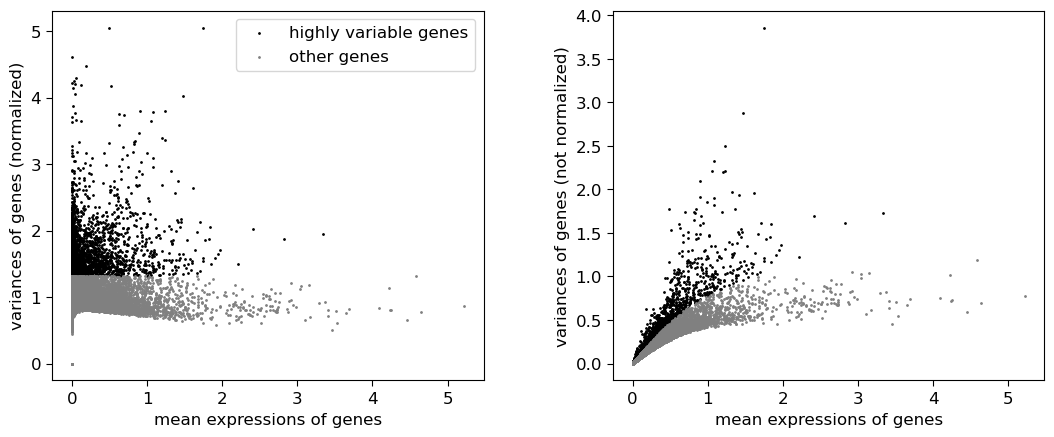

In [34]:
print(f"number of variable genes is: {var_features}")
sc.pl.highly_variable_genes(adata)

# Clustering 

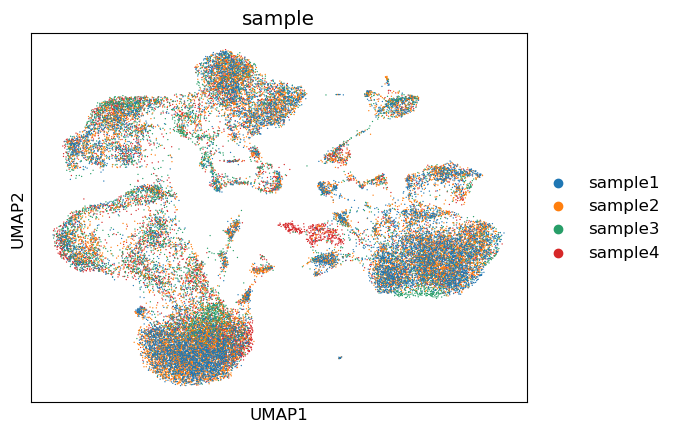

In [35]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [36]:
from numbers import Number

assert len(CLUSTERING_RANGE) == 3
assert all([isinstance(i, Number) for i in CLUSTERING_RANGE])

# If the min_range is 0, skip the first round and start from 0 + step.
min_range = (
    CLUSTERING_RANGE[0]
    if CLUSTERING_RANGE[0] > 0
    else CLUSTERING_RANGE[0] + CLUSTERING_RANGE[2]
)
max_range = CLUSTERING_RANGE[1]
step = CLUSTERING_RANGE[2]

for i in np.arange(min_range, max_range, step):
    resolution = np.around(i, decimals=3)
    sc.tl.leiden(adata=adata, key_added=f"leiden_{resolution}", resolution=resolution)

## Clustering Metrics

### Clustree

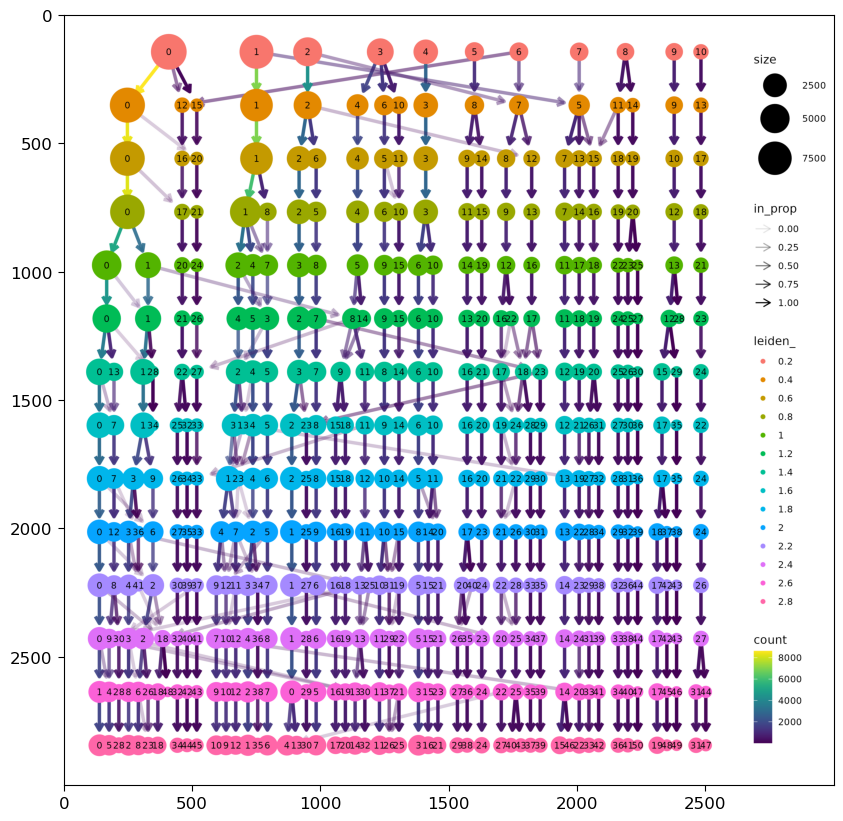

In [37]:
with TemporaryDirectory(dir=".") as f:
    input_dir = path.join(f, "leiden_clusters.csv")
    df = adata.obs.filter(regex="leiden_")
    df.to_csv(input_dir)
    system(f"Rscript ./utils/clustree.R -i {input_dir} -p leiden_ -o {f}")
    fig = plt.imread(path.join(f, "clustree.png"))

with rc_context({"figure.figsize": (10, 10)}):
    plt.imshow(fig)

In [38]:
# Source: https://evafast.github.io/blog/2019/06/28/example_content/

ig_obj = sc.Neighbors(adata).to_igraph()
results_df = pd.DataFrame(
    columns=["resolution", "number_of_clusters", "modularity", "davies_bouldin_score"]
)

for col in adata.obs.filter(regex="leiden_").columns:
    modularity_index = ig_obj.modularity(adata.obs[col].values.astype("int32"))
    davies_bouldin_avg = davies_bouldin_score(adata.obsm["X_pca"], adata.obs[col])
    df = pd.DataFrame(
        [
            [
                col,
                max(adata.obs[col].values.astype("int32")),
                davies_bouldin_avg,
                modularity_index,
            ]
        ],
        columns=[
            "resolution",
            "number_of_clusters",
            "davies_bouldin_score",
            "modularity",
        ],
    )

    results_df = pd.concat([results_df, df])
results_df = results_df.reset_index()


results_df

,index,resolution,number_of_clusters,modularity,davies_bouldin_score
0,0,leiden_0.2,10,0.808353,1.538444
1,0,leiden_0.4,15,0.824132,1.594780
2,0,leiden_0.6,20,0.829085,1.668602
3,0,leiden_0.8,21,0.830276,1.698063
4,0,leiden_1.0,25,0.834889,1.830185
5,0,leiden_1.2,28,0.833026,1.782162
6,0,leiden_1.4,30,0.829580,1.837044
7,0,leiden_1.6,36,0.824104,1.815010
8,0,leiden_1.8,36,0.818793,1.866773
9,0,leiden_2.0,39,0.814259,1.856190


### Modularity 

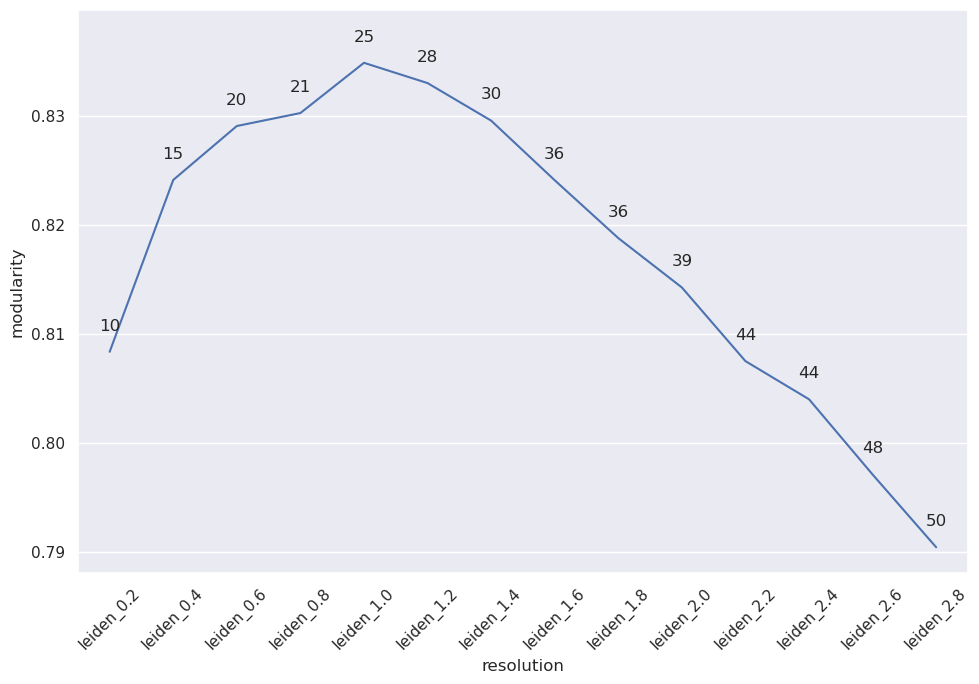

In [39]:
g = (
    so.Plot(results_df, "resolution", "modularity", text="number_of_clusters")
    .add(so.Line())
    .add(so.Text(), so.Shift(x=0.0, y=0.0025))
).theme({"figure.figsize": (10, 7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

### davies_bouldin_score

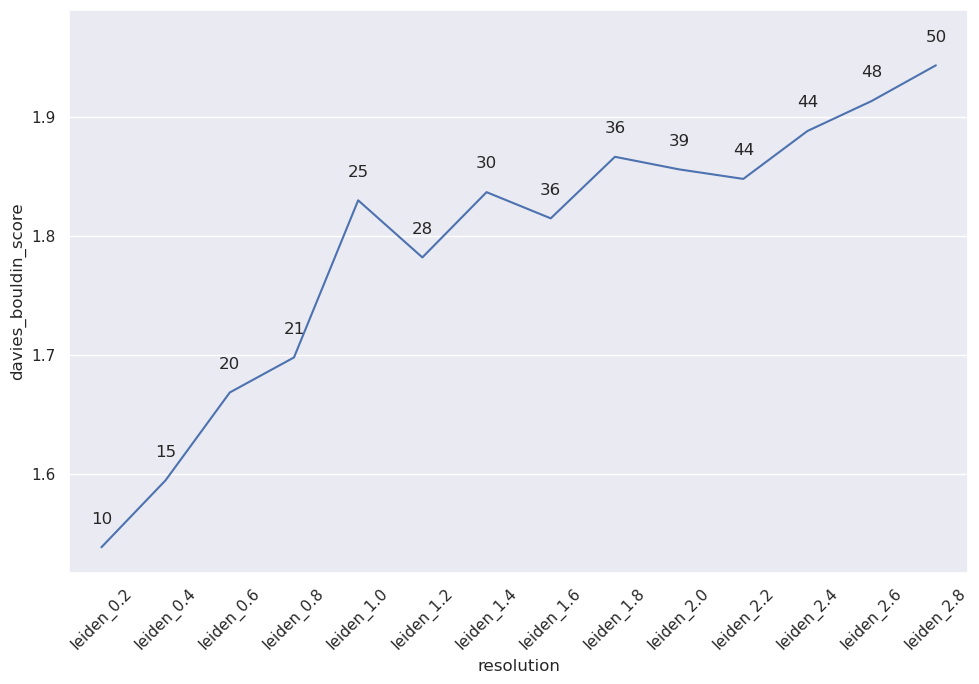

In [40]:
g = (
    so.Plot(results_df, "resolution", "davies_bouldin_score", text="number_of_clusters")
    .add(so.Line())
    .add(so.Text(), so.Shift(x=0.0, y=0.025))
).theme({"figure.figsize": (10, 7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

In [41]:
# Over-ride the FINAL_RESOLUTION
# FINAL_RESOLUTION = xx

if FINAL_RESOLUTION > 0:
    adata.uns["clustering_resolution"] = float(FINAL_RESOLUTION)
    sc.tl.leiden(adata, key_added="cluster", resolution=FINAL_RESOLUTION)
else:
    # TODO: Add a logger entry that the final_cluster resolution was not set.
    pass

## Showing all clustering solution

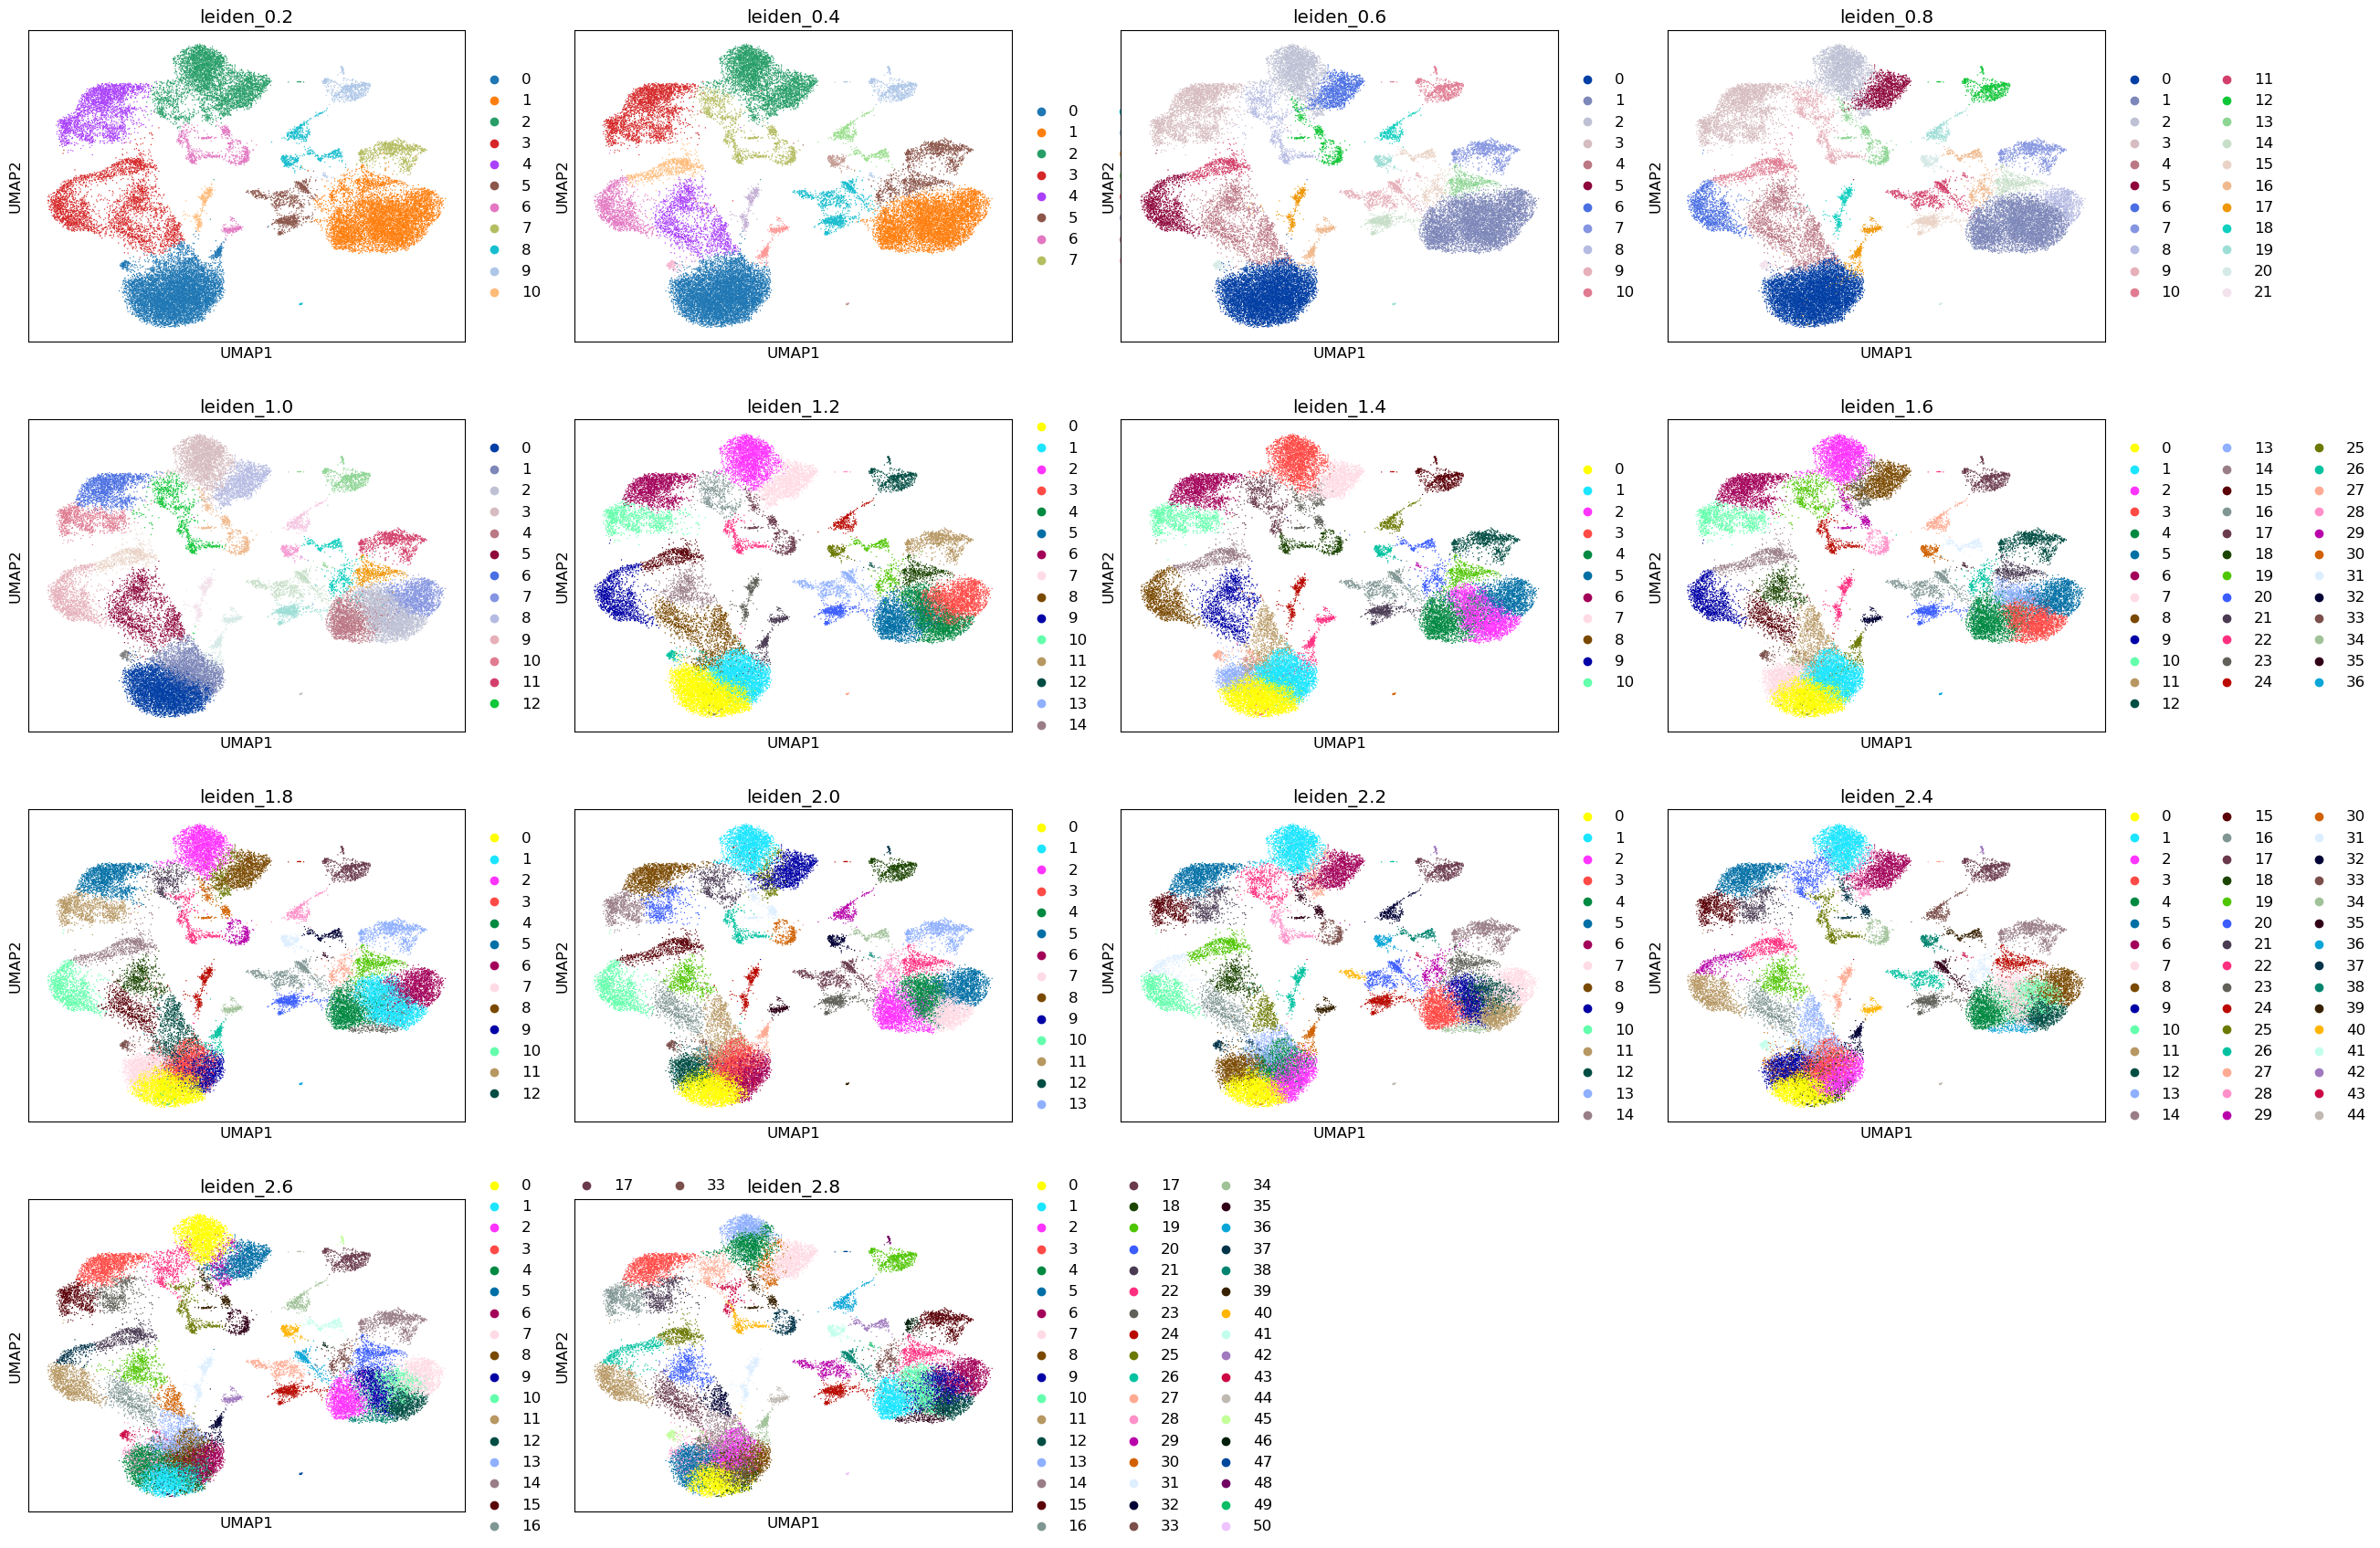

In [42]:
sc.pl.umap(adata, color=adata.obs.filter(regex="leiden_").columns)

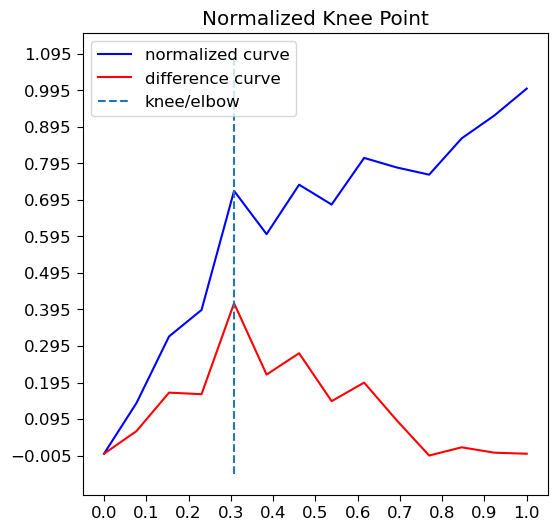

In [66]:
# from kneed import KneeLocator

# knee = KneeLocator(
#     results_df["resolution"].str.replace("leiden_", "").astype("float64").values,
#     results_df["davies_bouldin_score"].values,
#     S=1.0,
#     curve="concave",
#     direction="increasing",
# )

# knee.plot_knee_normalized()

In [ ]:
adata = adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session information

In [ ]:
session_info.show()